In [1]:
!pip install catboost

     |████████████████████████████████| 67.3MB 50kB/s 


In [173]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score,classification_report
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, RobustScaler
from sklearn.model_selection import KFold,StratifiedKFold, GroupKFold

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,AdaBoostClassifier

In [151]:

dftrain = pd.read_csv("/content/training_.csv")
dftest = pd.read_csv("/content/test.csv")

In [64]:
print('train',dftrain.shape,'test', dftest.shape)

train (1048, 28) test (210, 27)


In [129]:
dftrain=dftrain.drop_duplicates()
dftest=dftest.drop_duplicates()
print(dftrain.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048 entries, 0 to 1047
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   S.No                       1048 non-null   int64 
 1   Timestamp                  1048 non-null   object
 2   Age                        1048 non-null   int64 
 3   Gender                     1048 non-null   object
 4   Country                    1048 non-null   object
 5   state                      636 non-null    object
 6   self_employed              1030 non-null   object
 7   family_history             1048 non-null   object
 8   treatment                  1048 non-null   object
 9   work_interfere             812 non-null    object
 10  no_employees               1048 non-null   object
 11  remote_work                1048 non-null   object
 12  tech_company               1048 non-null   object
 13  benefits                   1048 non-null   object
 14  care_opt

In [66]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 0 to 209
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   S.No                       210 non-null    int64 
 1   Timestamp                  210 non-null    object
 2   Age                        210 non-null    int64 
 3   Gender                     210 non-null    object
 4   Country                    210 non-null    object
 5   state                      107 non-null    object
 6   self_employed              210 non-null    object
 7   family_history             210 non-null    object
 8   work_interfere             182 non-null    object
 9   no_employees               210 non-null    object
 10  remote_work                210 non-null    object
 11  tech_company               210 non-null    object
 12  benefits                   210 non-null    object
 13  care_options               210 non-null    object
 14  wellness_p

In [67]:
dftrain

S.No  ...                                           comments
0        1  ...                                                NaN
1        2  ...                                                NaN
2        3  ...                                                NaN
3        4  ...                                                NaN
4        5  ...                                                NaN
...    ...  ...                                                ...
1043  1044  ...                                                NaN
1044  1045  ...                                                NaN
1045  1046  ...                                                NaN
1046  1047  ...  I suffered of panic attacks and agoraphobia fo...
1047  1048  ...                                                NaN

[1048 rows x 28 columns]

In [68]:
dftrain.isna().sum()

S.No                           0
Timestamp                      0
Age                            0
Gender                         0
Country                        0
state                        412
self_employed                 18
family_history                 0
treatment                      0
work_interfere               236
no_employees                   0
remote_work                    0
tech_company                   0
benefits                       0
care_options                   0
wellness_program               0
seek_help                      0
anonymity                      0
leave                          0
mental_health_consequence      0
phys_health_consequence        0
coworkers                      0
supervisor                     0
mental_health_interview        0
phys_health_interview          0
mental_vs_physical             0
obs_consequence                0
comments                     916
dtype: int64

In [69]:
dftest.isna().sum()


S.No                           0
Timestamp                      0
Age                            0
Gender                         0
Country                        0
state                        103
self_employed                  0
family_history                 0
work_interfere                28
no_employees                   0
remote_work                    0
tech_company                   0
benefits                       0
care_options                   0
wellness_program               0
seek_help                      0
anonymity                      0
leave                          0
mental_health_consequence      0
phys_health_consequence        0
coworkers                      0
supervisor                     0
mental_health_interview        0
phys_health_interview          0
mental_vs_physical             0
obs_consequence                0
comments                     178
dtype: int64

In [70]:
dftrain.columns

Index(['S.No', 'Timestamp', 'Age', 'Gender', 'Country', 'state',
       'self_employed', 'family_history', 'treatment', 'work_interfere',
       'no_employees', 'remote_work', 'tech_company', 'benefits',
       'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'comments'],
      dtype='object')

In [71]:
dftrain['no_employees'].value_counts()

6-25              245
26-100            238
More than 1000    227
100-500           150
1-5               133
500-1000           55
Name: no_employees, dtype: int64

In [72]:
dftrain['anonymity'].value_counts()

Don't know    685
Yes           311
No             52
Name: anonymity, dtype: int64

In [152]:
test=dftest.copy()
dftrain.drop(['S.No', 'Timestamp','comments','state'],axis=1,inplace=True)
test.drop(['S.No', 'Timestamp','comments','state'],axis=1,inplace=True)

In [153]:
dftrain['Gender'].replace(['male','M','m','Make','Man','Male-ish','Mail','maile','Male','Male','msle','Mal','Guy (-ish) ^_^','Malr','A little about you'],'Male',inplace=True)
dftrain['Gender'].replace(['female','F','f','Woman','Female','Femake','woman'],'Female',inplace=True)
dftrain['Gender'].replace(['Female (trans)','Trans woman','Trans-female','Trans woman','non-binary','fluid','queer/she/they','Genderqueer','queer'],'Queer',inplace=True)
dftrain['Gender'].replace(['Androgyne','male leaning androgynous','Neuter'],'Androgyne',inplace=True)
dftrain['Gender'].replace(['Cis Male','Male (CIS)','something kinda male?','cis male'],"cis Male",inplace=True)
dftrain['Gender'].replace(['Cis Female','cis-female/femme','Female (cis)'],"cis female",inplace=True)
dftrain['Gender'].replace(['All','Nah','Enby'],"Agender",inplace=True)

test['Gender'].replace(['male','M','m','Male','Male','p'],'Male', inplace=True)
test['Gender'].replace(['Cis Man','ostensibly male, unsure what that really means'],'cis male',inplace=True)
test['Gender'].replace(['Female','female','F','f','Woman','femail'],'Female', inplace=True)      
test['Gender'].replace(['Female','female','F','f','Woman','femail'],'Female', inplace=True)

dftrain['Country'].replace(['Bahamas, The'],"Bahamas",inplace=True)

dftrain['Age'].replace([99999999999,-29,-1726,329,-1726],31, inplace=True)
test['Age'].replace(-1,32,inplace=True)

dftrain['no_employees'].replace('1-5','few',inplace=True)
dftrain['no_employees'].replace('6-25','very small',inplace=True)
dftrain['no_employees'].replace('26-100','small',inplace=True)
dftrain['no_employees'].replace('100-500','medium',inplace=True)
dftrain['no_employees'].replace('500-1000','large',inplace=True)
dftrain['no_employees'].replace('More than 1000','very large',inplace=True)

test['no_employees'].replace('1-5','few',inplace=True)
test['no_employees'].replace('6-25','very small',inplace=True)
test['no_employees'].replace('26-100','small',inplace=True)
test['no_employees'].replace('100-500','medium',inplace=True)
test['no_employees'].replace('500-1000','large',inplace=True)
test['no_employees'].replace('More than 1000','very large',inplace=True)

In [150]:
test['no_employees'].value_counts()

very large    55
small         51
very small    45
few           28
medium        26
large          5
Name: no_employees, dtype: int64

In [132]:
dftrain['mental_vs_physical'].value_counts()

Don't know    471
Yes           297
No            280
Name: mental_vs_physical, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


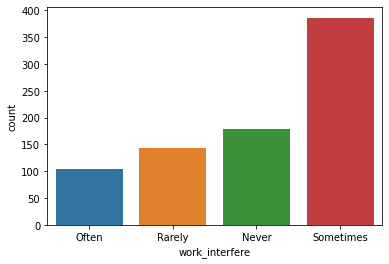

In [133]:
sns.countplot(dftrain['work_interfere'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


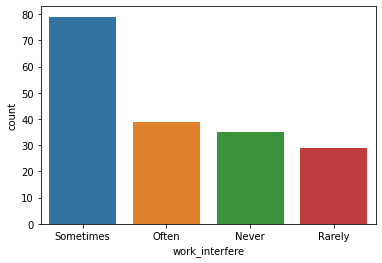

In [77]:
sns.countplot(test['work_interfere'])

In [154]:
dftrain['work_interfere']=dftrain['work_interfere'].fillna('Sometimes')
test['work_interfere']=test['work_interfere'].fillna('Sometimes')

dftrain['self_employed']=dftrain['self_employed'].fillna('No')


In [135]:
coln=dftrain.columns

In [136]:

for col in coln:
    print(col,dftrain[col].unique())
    

Age [37 44 32 31 33 35 39 42 23 29 36 27 46 41 34 30 40 38 50 24 18 28 26 22
 19 25 45 21 43 56 60 54 55 48 20 57 58 47 62 51 65 49  5 53 61  8]
Gender ['Female' 'Male' 'Queer' 'cis female' 'cis Male' 'Agender' 'Female '
 'Androgyne' 'Male ']
Country ['United States' 'Canada' 'United Kingdom' 'Bulgaria' 'France' 'Portugal'
 'Netherlands' 'Switzerland' 'Poland' 'Australia' 'Germany' 'Russia'
 'Mexico' 'Brazil' 'Slovenia' 'Costa Rica' 'Austria' 'Ireland' 'India'
 'South Africa' 'Italy' 'Sweden' 'Colombia' 'Latvia' 'Romania' 'Belgium'
 'New Zealand' 'Zimbabwe' 'Spain' 'Finland' 'Uruguay' 'Israel'
 'Bosnia and Herzegovina' 'Hungary' 'Singapore' 'Japan' 'Nigeria'
 'Croatia' 'Norway' 'Thailand' 'Denmark' 'Bahamas']
self_employed ['No' 'Yes']
family_history ['No' 'Yes']
treatment ['Yes' 'No']
work_interfere ['Often' 'Rarely' 'Never' 'Sometimes']
no_employees ['6-25' 'very large' '26-100' '100-500' '1-5' '500-1000']
remote_work ['No' 'Yes']
tech_company ['Yes' 'No']
benefits ['Yes' "Don't know

In [137]:
colo=test.columns
colo

Index(['Age', 'Gender', 'Country', 'self_employed', 'family_history',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence'],
      dtype='object')

In [138]:
for colo in colo:
    print(colo,test[colo].unique())

Age [39 26 23 35 36 42 27 33 31 28 29 44 25 24 34 48 43 41 40 37 32 30 38 11
 45 50 46 20 21 51 72 56 60 22]
Gender ['Male' 'Female' 'Male ' 'cis male']
Country ['United Kingdom' 'United States' 'Switzerland' 'Canada' 'Germany'
 'South Africa' 'Greece' 'Netherlands' 'France' 'Australia' 'India'
 'Croatia' 'New Zealand' 'Moldova' 'Sweden' 'Belgium' 'Israel' 'Singapore'
 'Poland' 'Colombia' 'Georgia' 'China' 'Bulgaria' 'Italy' 'Ireland'
 'Brazil' 'Czech Republic' 'Philippines' 'Finland']
self_employed ['Yes' 'No']
family_history ['Yes' 'No']
work_interfere ['Sometimes' 'Often' 'Never' 'Rarely']
no_employees ['1-5' 'very large' '26-100' '500-1000' '6-25' '100-500']
remote_work ['Yes' 'No']
tech_company ['Yes' 'No']
benefits ['No' 'Yes' "Don't know"]
care_options ['Yes' 'No' 'Not sure']
wellness_program ['Yes' 'No' "Don't know"]
seek_help ['Yes' 'No' "Don't know"]
anonymity ['Yes' "Don't know" 'No']
leave ['Somewhat difficult' "Don't know" 'Very easy' 'Somewhat easy'
 'Very difficult']
men

In [139]:

for col in coln:
    print(col,'\n',dftrain[col].value_counts().to_dict(),'\n')

Age 
 {29: 73, 32: 64, 26: 63, 33: 63, 27: 61, 31: 61, 28: 56, 30: 56, 34: 52, 35: 49, 25: 48, 23: 41, 24: 38, 37: 36, 36: 31, 38: 30, 40: 26, 39: 26, 43: 23, 22: 20, 42: 17, 41: 15, 21: 15, 19: 9, 45: 9, 44: 8, 46: 7, 18: 7, 48: 5, 50: 5, 51: 4, 20: 4, 49: 4, 54: 3, 55: 3, 56: 3, 57: 3, 47: 2, 8: 1, 65: 1, 62: 1, 53: 1, 58: 1, 60: 1, 61: 1, 5: 1} 

Gender 
 {'Male': 824, 'Female': 197, 'Queer': 9, 'cis Male': 5, 'Agender': 4, 'Androgyne': 3, 'cis female': 3, 'Female ': 2, 'Male ': 1} 

Country 
 {'United States': 644, 'United Kingdom': 153, 'Canada': 64, 'Germany': 37, 'Netherlands': 18, 'Australia': 18, 'Ireland': 13, 'France': 11, 'India': 8, 'Sweden': 6, 'Switzerland': 6, 'New Zealand': 6, 'Italy': 6, 'Poland': 5, 'Brazil': 5, 'Belgium': 4, 'South Africa': 4, 'Israel': 4, 'Bulgaria': 3, 'Russia': 3, 'Austria': 3, 'Mexico': 3, 'Denmark': 2, 'Singapore': 2, 'Finland': 2, 'Portugal': 2, 'Bosnia and Herzegovina': 1, 'Nigeria': 1, 'Romania': 1, 'Colombia': 1, 'Spain': 1, 'Slovenia': 1, 

In [ ]:
#for i in dftrain.columns:
#     if(dftrain[i].dtype==object):
#        le=LabelEncoder()
#        dftrain[i]=le.fit_transform(dftrain[i])
        
        

In [ ]:
#for i in test.columns:
#     if(test[i].dtype==object):
#        le=LabelEncoder()
#        test[i]=le.fit_transform(test[i])

In [ ]:
#dummycols=['Country','work_interfere','no_employees','benefits','care_options','wellness_program','seek_help','anonymity','leave','mental_health_consequence','phys_health_consequence','coworkers']

#for i in dummycols:
#     a=pd.get_dummies(data=dftrain,columns=[i],drop_first=True)

In [155]:
xtrain=dftrain.drop(['treatment'],axis=1)
ytrain=dftrain['treatment']

In [156]:
catfeatures=['Gender', 'Country', 'self_employed', 'family_history',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence']

In [142]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048 entries, 0 to 1047
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        1048 non-null   int64 
 1   Gender                     1048 non-null   object
 2   Country                    1048 non-null   object
 3   self_employed              1048 non-null   object
 4   family_history             1048 non-null   object
 5   work_interfere             1048 non-null   object
 6   no_employees               1048 non-null   object
 7   remote_work                1048 non-null   object
 8   tech_company               1048 non-null   object
 9   benefits                   1048 non-null   object
 10  care_options               1048 non-null   object
 11  wellness_program           1048 non-null   object
 12  seek_help                  1048 non-null   object
 13  anonymity                  1048 non-null   object
 14  leave   

In [157]:

model = CatBoostClassifier(n_estimators=15000,random_state=181219,learning_rate=0.030,eval_metric='F1'
                              )
model.fit(xtrain,ytrain,verbose=500,early_stopping_rounds=200,cat_features=catfeatures,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7373448	total: 43.4ms	remaining: 10m 50s
500:	learn: 0.9265873	total: 6.29s	remaining: 3m 2s
1000:	learn: 0.9852507	total: 13s	remaining: 3m 2s
1500:	learn: 0.9951028	total: 20.1s	remaining: 3m
2000:	learn: 1.0000000	total: 27.1s	remaining: 2m 55s
2500:	learn: 1.0000000	total: 34.6s	remaining: 2m 53s
3000:	learn: 1.0000000	total: 42.4s	remaining: 2m 49s
3500:	learn: 1.0000000	total: 50.4s	remaining: 2m 45s
4000:	learn: 1.0000000	total: 58.5s	remaining: 2m 40s
4500:	learn: 1.0000000	total: 1m 6s	remaining: 2m 35s
5000:	learn: 1.0000000	total: 1m 15s	remaining: 2m 30s
5500:	learn: 1.0000000	total: 1m 24s	remaining: 2m 25s
6000:	learn: 1.0000000	total: 1m 33s	remaining: 2m 19s
6500:	learn: 1.0000000	total: 1m 42s	remaining: 2m 13s
7000:	learn: 1.0000000	total: 1m 51s	remaining: 2m 7s
7500:	learn: 1.0000000	total: 2m 1s	remaining: 2m 1s
8000:	learn: 1.0000000	total: 2m 11s	remaining: 1m 55s
8500:	learn: 1.0000000	total: 2m 22s	remaining: 1m 48s
9000:	learn: 1.0000000	total: 2m 

In [158]:
trainpred=model.predict(xtrain)

In [159]:
from sklearn.metrics import f1_score
f1_score(ytrain,trainpred,pos_label='Yes')

0.9126594700686949

In [168]:
testpred=model.predict(test)
testpred=pd.DataFrame(testpred)

In [169]:
sno=pd.DataFrame(dftest['S.No'])

testpred.columns=["treatment"]

In [170]:
concatinated=pd.concat([sno,testpred],axis=1)
concatinated.to_csv("pga14.csv")